# Multiple Type Experiment

In [1]:
import warnings;
warnings.filterwarnings('ignore');

from time import sleep
from tqdm.auto import tqdm

import sys
import importlib
import numpy as np
import nbformat
# import plotly.express
# import plotly.express as px
import pandas as pd
import cvxpy as cp
import scipy.optimize as optimization
import matplotlib.pyplot as plt
import seaborn as sns

from solvers import generate_cvxpy_solve, verify_fairness, get_utility, offline_opt, fixed_threshold, hope_online, hope_full, hope_guardrail
from radar_plot import *

In [2]:
df = pd.read_csv('../MFP Regular Sites 2019 - addresses2019 updated.csv')

In [3]:
df.columns

Index(['Site Name', 'Address', 'City', 'State', 'ZIP', 'latitude', 'longitude',
       'Number of Visits in 2019', 'Average Demand per Visit',
       'StDev(Demand per Visit)', 'Unnamed: 10',
       'Demand per Visit == the number of clients serviced on that visit'],
      dtype='object')

In [4]:
locations = df[['latitude', 'longitude']]
data_weights = df['Average Demand per Visit']
data_stdev = df['StDev(Demand per Visit)']

### Scaling with n

In [5]:
data = []

np.random.seed(5)

# seed 2 - 47 locations

num_types = 3
num_resources = 5
dist_types = np.asarray([.25, .3, 1-.25-.3])
print(dist_types)

weights = np.asarray([[3.9, 3.0, 2.8, 2.7, .1], [3.9, 3.0, .1, 2.7, .1], [3.9, 3.0, 2.8, 2.7, 1.9]])
sum_of_rows = weights.sum(axis=1)
weights = weights / sum_of_rows[:, np.newaxis]

algo_list = {'Fixed Threshold': fixed_threshold,
             'Hope Guardrail $L_T = 1/2$': lambda a,b,c,d,e,f: hope_guardrail(a,b,c,d,e,f,1/2),
             'Hope Guardrail $L_T = 1/3$': lambda a,b,c,d,e,f: hope_guardrail(a,b,c,d,e,f,1/3),
             'Hope Online': hope_online,
             'Hope Full': hope_full}
             

num_algo = len(algo_list)

num_iterations = 200

# num_iterations = 1

max_n = len(data_stdev)
utility = 'leontief'
print(max_n)

[0.25 0.3  0.45]
70


In [6]:


num_groups = np.arange(5, max_n, 10)

for n in tqdm(num_groups):
    print('Num Locations: ' + str(n))

    alloc_diff = np.zeros((len(algo_list), num_iterations, n, num_types, num_resources)) 
    
    for i in range(num_iterations):
        
        index = np.random.choice(max_n, n, replace=False)
        mean_size = np.asarray([dist_types * data_weights[index].to_numpy()[j] for j in range(n)])
        stdev_size = np.asarray([(dist_types**2) * data_weights[index].to_numpy()[j] for j in range(n)])
             
        budget = np.asarray([np.sum(mean_size)]*num_resources)
        
        size = np.maximum(1, np.random.normal(mean_size, stdev_size))
        
        
        # print('Size: ' + str(size))
        total_num_types = np.sum(size, axis=0)

        
        prob, solver = generate_cvxpy_solve(num_types, num_resources, utility)

        
        opt = offline_opt(budget, size, weights, solver)
        # print('offline opt: ' + str(opt))
        index = 0
        for algo in algo_list:
            
        
            sol, waste = algo_list[algo](budget, size, mean_size, stdev_size, weights, solver)

            waste, envy, proportionality, c_envy = verify_fairness(weights, sol, np.asarray(size), np.asarray(budget), utility, opt)

            data_dict = {'NumGroups': n, 'Algorithm': algo, 'Norm': 'Hindsight_Envy', 'Value': envy}
            data.append(data_dict)
            data_dict = {'NumGroups': n, 'Algorithm':algo, 'Norm': 'Proportionality', 'Value': proportionality}
            data.append(data_dict)
            data_dict = {'NumGroups': n, 'Algorithm':algo, 'Norm': 'Waste', 'Value': waste}
            data.append(data_dict)
            data_dict = {'NumGroups': n, 'Algorithm':algo, 'Norm': 'Counterfactual_Envy', 'Value': c_envy}
            data.append(data_dict)

  0%|          | 0/7 [00:00<?, ?it/s]

Num Locations: 5
Num Locations: 15
Num Locations: 25
Num Locations: 35
Num Locations: 45
Num Locations: 55
Num Locations: 65


In [7]:
df = pd.DataFrame.from_records(data)
df.to_csv('./data_leontief/multi_fbst.csv', index=False)
df = pd.read_csv('./data_leontief/multi_fbst.csv')

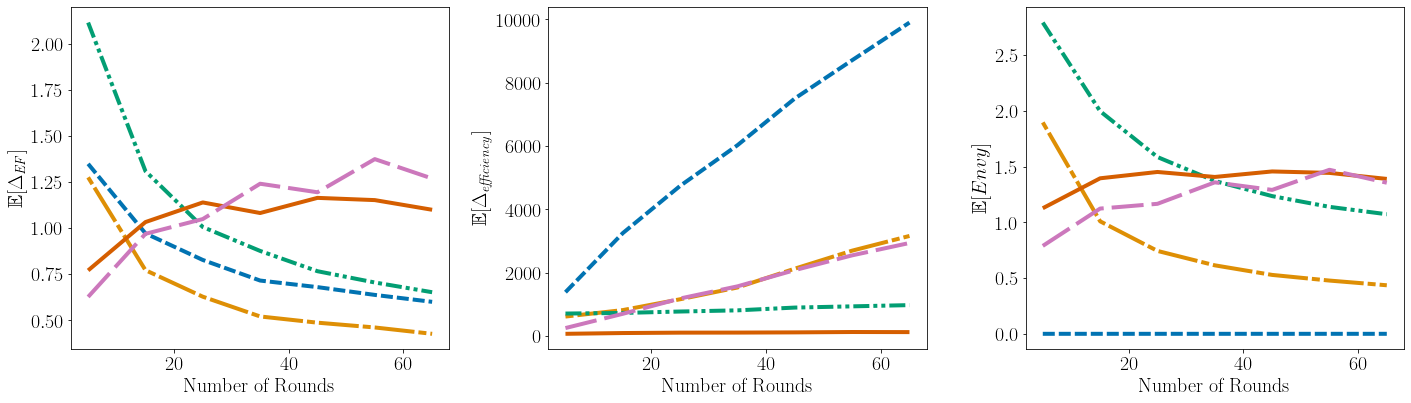

In [8]:

df.columns
df = df.assign(Algorithm = lambda df: df.Algorithm.replace({'fixed_threshold': 'Fixed Threshold', 'hope_guardrail_13': 'Guarded Hope $L_T = T^{-1/3}$', 'hope_guardrail_12': 'Guarded Hope $L_T = T^{-1/2}$'}))



plt.style.use('PaperDoubleFig.mplstyle.txt')
plt.rc('text.latex', preamble=r'\usepackage{amsfonts}')

# Make some style choices for plotting 
# colorWheel =['#2bd1e5',
#             '#281bf5',
#              '#db1bf5',
#              '#F5CD1B',
#             '#FF5733','#9cf51b',]
dashesStyles = [[3,1],
            [2,1,10,1],
            [4, 1, 1, 1, 1, 1],[1000,1],[8,2]]


#filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
#plt.figure(figsize=(20,10))
#plt.title('Simple Distribution L1')
#sns.lineplot(x='NumGroups', y='value', hue='variable', data=df[df.Norm == 'L1'])

filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
dash_styles = ["",
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2)]

# fig = plt.figure(figsize=(20,6))
plt.rc('text', usetex=True)



fg, axs = plt.subplots(1,3, sharex='all', figsize=(20,6))
sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)],
                     data=df[df.Norm == 'Counterfactual_Envy'], ax = axs[0], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)
sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)], 
             data=df[df.Norm == 'Waste'], ax = axs[1], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)

sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)], 
             data=df[df.Norm == 'Hindsight_Envy'], ax = axs[2], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)


axs[0].get_legend().remove()
axs[0].set_ylabel('$\mathbb{E}[\Delta_{\it EF}]$')
axs[0].set_xlabel('Number of Rounds')

axs[1].set_ylabel('$\mathbb{E}[\Delta_{\it efficiency}]$')
axs[1].set_xlabel('Number of Rounds')
axs[1].get_legend().remove()

axs[2].get_legend().remove()
axs[2].set_ylabel(r'$\mathbb{E}[Envy]$')
axs[2].set_xlabel('Number of Rounds')

# axs[2].legend(ncol = 1, loc= 'upper right')




plt.show()
fg.savefig('./figures/fbst_multi_leontief.pdf', bbox_inches = 'tight',pad_inches = 0.01, dpi=900)

### Group by Group Difference

In [9]:
fair_data = []


algo_list = {'Fixed Threshold': fixed_threshold,
             'Hope Guardrail $L_T = 1/2$': lambda a,b,c,d,e,f: hope_guardrail(a,b,c,d,e,f,1/2),
             'Hope Guardrail $L_T = 1/3$': lambda a,b,c,d,e,f: hope_guardrail(a,b,c,d,e,f,1/3),
             'Hope Online': hope_online,
             'Hope Full': hope_full}             

num_algo = len(algo_list)

num_iterations = 200
n = 10

for i in tqdm(range(num_iterations)):

    index = np.random.choice(max_n, n, replace=False)
    mean_size = np.asarray([dist_types * data_weights[index].to_numpy()[j] for j in range(n)])
    stdev_size = np.asarray([(dist_types**2) * data_weights[index].to_numpy()[j] for j in range(n)])

    budget = np.asarray([np.sum(mean_size)]*num_resources)

    size = np.maximum(1, np.random.normal(mean_size, stdev_size))


#     print('Size: ' + str(size))
    total_num_types = np.sum(size, axis=0)


    prob, solver = generate_cvxpy_solve(num_types, num_resources, utility)


    # print(num_types, num_resources, budget.shape size.shape, )

    opt = offline_opt(budget, size, weights, solver)

    # print('opt: ' + str(opt))
    index = 0
    for algo in algo_list:

        sol, waste = algo_list[algo](budget, size, mean_size, stdev_size, weights, solver)
        # print('budget: ' + str(budget))
        # print('waste: ' + str(waste))
        # print(algo + ' : ' + str(sol))
        waste, envy, proportionality, c_envy = verify_fairness(weights, sol, np.asarray(size), np.asarray(budget), utility, opt)

        fair_data.append({'Iteration':i, 'Algorithm':algo, 
                          '$\Delta_{\it efficiency}$': waste, 
                          '$\Delta_{\it Prop}$': proportionality, 
#                           '\textsc{NSW}'.encode('unicode_escape').decode('utf'): nsw,
                         '\textsc{Envy}'.encode('unicode_escape').decode('utf'): envy, 
                          '$\Delta_{\it EF}$': c_envy
                            })


  0%|          | 0/200 [00:00<?, ?it/s]

In [10]:
fair_df = pd.DataFrame.from_records(fair_data)
fair_df.to_csv('./data_leontief/multi_fbst_fair.csv', index=False)
fair_df = pd.read_csv('./data_leontief/multi_fbst_fair.csv')

### Printing Fairness Metrics

In [11]:
# print(fair_df.columns)
fair_df = fair_df.groupby(['Algorithm']).mean()
print(fair_df.drop(['Iteration'], axis=1))

fair_df['$\Delta_{\it efficiency}$'] = (-1)*fair_df['$\Delta_{\it efficiency}$']
fair_df['\textsc{Envy}'.encode('unicode_escape').decode('utf')] = (-1)*fair_df['\textsc{Envy}'.encode('unicode_escape').decode('utf')]
fair_df['$\Delta_{\it EF}$'] = (-1)* fair_df['$\Delta_{\it EF}$']
fair_df['$\Delta_{\it Prop}$'] = (-1) * fair_df['$\Delta_{\it Prop}$']

                            $\Delta_{\it efficiency}$  $\Delta_{\it Prop}$  \
Algorithm                                                                    
Fixed Threshold                           2421.021987             1.142130   
Hope Full                                  514.853733             0.874399   
Hope Guardrail $L_T = 1/2$                 705.795622             0.897553   
Hope Guardrail $L_T = 1/3$                 705.018715             0.896838   
Hope Online                                 91.271544             0.507631   

                            \textsc{Envy}  $\Delta_{\it EF}$  
Algorithm                                                     
Fixed Threshold              2.174359e-07           1.142130  
Hope Full                    1.042346e+00           0.876692  
Hope Guardrail $L_T = 1/2$   1.301248e+00           0.975811  
Hope Guardrail $L_T = 1/3$   2.422768e+00           1.601046  
Hope Online                  1.457285e+00           1.060014  


In [12]:
fair_df = normalize(fair_df).drop(['Iteration'], axis=1)

print(fair_df)

                            $\Delta_{\it efficiency}$  $\Delta_{\it Prop}$  \
Algorithm                                                                    
Fixed Threshold                              0.100000             0.100000   
Hope Full                                    0.836367             0.479761   
Hope Guardrail $L_T = 1/2$                   0.762605             0.446919   
Hope Guardrail $L_T = 1/3$                   0.762905             0.447933   
Hope Online                                  1.000000             1.000000   

                            \textsc{Envy}  $\Delta_{\it EF}$  
Algorithm                                                     
Fixed Threshold                  1.000000           0.670197  
Hope Full                        0.612794           1.000000  
Hope Guardrail $L_T = 1/2$       0.516618           0.876846  
Hope Guardrail $L_T = 1/3$       0.100000           0.100000  
Hope Online                      0.458654           0.772224  


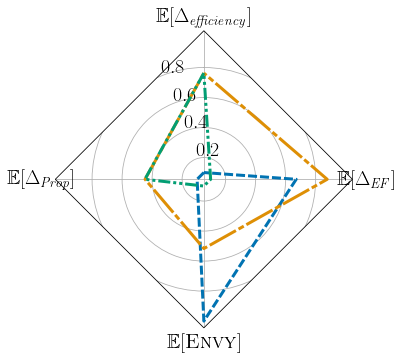

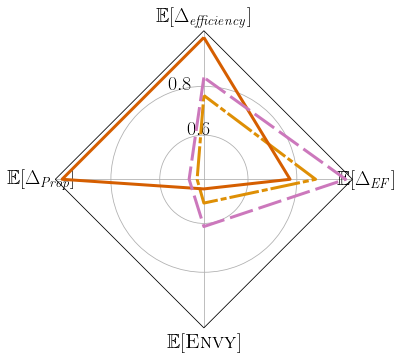

In [13]:
# number of variable


from math import pi
plt.style.use('PaperDoubleFig.mplstyle.txt')

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsfonts}')




N = len(list(fair_df))
theta = radar_factory(N, frame='polygon')

spoke_labels = ['$\\mathbb{E}[\\Delta_{\\it efficiency}]$', '$\\mathbb{E}[\\Delta_{\\it Prop}]$', '$\\mathbb{E}[\\textsc{Envy}]$', '$\\mathbb{E}[\\Delta_{\\it EF}]$']

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
# ax.set_title('Comparison of Fairness Metrics',  position=(0.5, 1.1), ha='center')
dashesStyles = [[3,1],
            [2,1,10,1],
            [4, 1, 1, 1, 1, 1],[1000,1],[8,2]]

first_plot = { algo : algo_list[algo] for algo in ['Fixed Threshold', 'Hope Guardrail $L_T = 1/2$', 'Hope Guardrail $L_T = 1/3$']}
second_plot = { algo : algo_list[algo] for algo in ['Hope Guardrail $L_T = 1/2$', 'Hope Online', 'Hope Full']}


index = 0
for algo in first_plot:
    values = fair_df.loc[algo].to_numpy()
    ax.plot(theta, values, linewidth=3, dashes=dashesStyles[index], label=algo, color = sns.color_palette('colorblind', len(algo_list))[index])
    ax.fill(theta, values, color = sns.color_palette('colorblind', len(algo_list))[index],  alpha=0)
    index += 1
ax.set_varlabels(spoke_labels)

# plt.legend(loc='right', bbox_to_anchor=(2.15, .5))

plt.savefig('./figures/multi_fbst_leontief_guardrail_radar.pdf')
plt.show()





fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])


dashesStyles = [
            [2,1,10,1],
            [1000,1],[8,2]]

color_list = [sns.color_palette("colorblind", len(algo_list))[1], sns.color_palette("colorblind", len(algo_list))[3], sns.color_palette("colorblind", len(algo_list))[4]]

index = 0
for algo in second_plot:
    values = fair_df.loc[algo].to_numpy()
    ax.plot(theta, values, linewidth=3, dashes=dashesStyles[index], label=algo, color = color_list[index])
    ax.fill(theta, values, color = sns.color_palette('colorblind', len(algo_list))[index],  alpha=0)
    index += 1
ax.set_varlabels(spoke_labels)

# plt.legend(loc='right', bbox_to_anchor=(2.15, .5))

plt.savefig('./figures/multi_fbst_leontief_heuristic_radar.pdf')
plt.show()


